In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow import keras

from bitsback import *

# Fix random seed (just in case)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)
random.seed(42)

# Enable deterministic results on GPU
tf.config.experimental.enable_op_determinism()

2023-10-18 01:53:29.986773: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 01:53:29.986848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 01:53:29.986892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 01:53:29.993775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

orig_x_train = x_train
orig_x_test = x_test

# Scale to be between [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(x_train.shape)

mnist_digits = x_train
mnist_digits = np.expand_dims(mnist_digits, -1)

(60000, 28, 28)


[-1.         -1.         -1.         -0.3647059   0.88235295  0.9843137
  0.9843137  -0.06666667 -0.8039216  -1.        ]


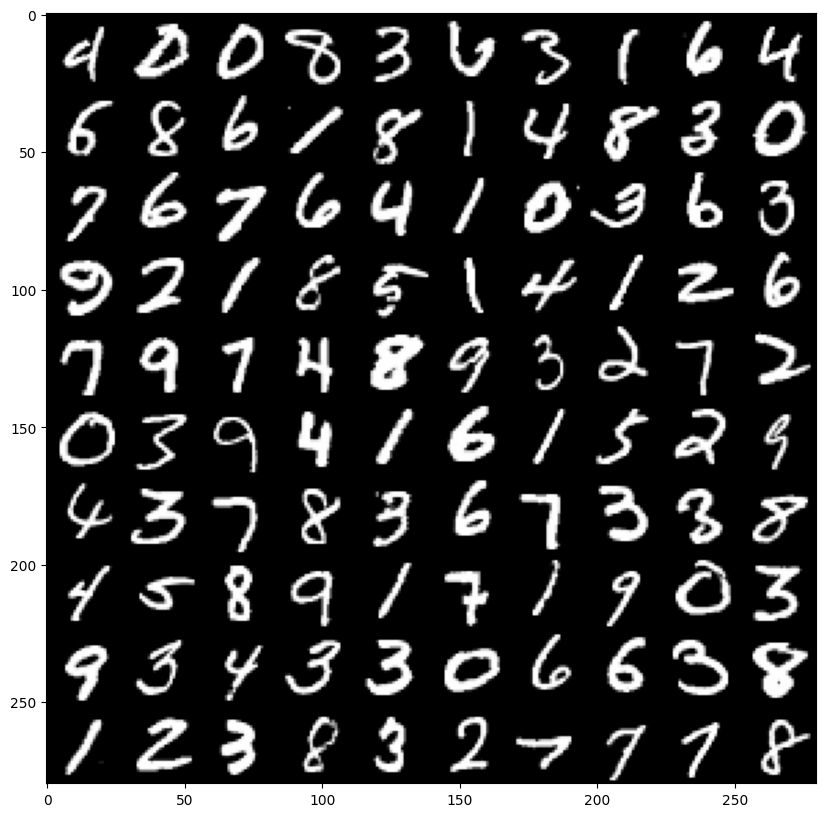

In [3]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

print(mnist_digits[0, 14, 10:20].reshape(10))
display_digits(mnist_digits)

In [4]:
enc = keras.models.load_model('vae-encoder')
dec = keras.models.load_model('vae-decoder')

2023-10-18 01:53:32.266661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 01:53:32.270073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 01:53:32.270102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 01:53:32.272639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 01:53:32.272670: I tensorflow/compile

In [5]:
# Double check that the encoder and decoder are deterministic
x = tf.random.normal(shape=(1, 28, 28))
a = enc.predict(x)
a_mu, a_log_var = a[0], a[1]
b = enc.predict(x)
b_mu, b_log_var = b[0], b[1]
assert np.allclose(a_mu, b_mu, rtol=1e-08, atol=1e-08)
assert np.allclose(a_log_var, b_log_var, rtol=1e-08, atol=1e-08)

x = tf.random.normal(shape=(1, 50))
a = dec.predict(x)
b = dec.predict(x)
assert np.allclose(a, b, rtol=1e-08, atol=1e-08)

2023-10-18 01:53:35.670744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


1/1 [==============================] - 2s 2s/step


2023-10-18 01:53:36.177965: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-18 01:53:36.227385: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 20ms/step


In [6]:
n_components = 3 
latent_size = 50
quant_bits = 16
num_images = len(orig_x_test)

stack = np.random.randint(low=0, high=(1 << 32) - 1, size=50, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))
init_stack = stack.copy()

In [7]:
# Search for optimal bin_bits
bin_bits = 14
best_bits_per_dim = 1e10
for b in [3, 4, 5, 6, 7, 8, 10, 14]:
    stack = init_stack.copy()
    stats = {}
    for i in range(num_images):
        stack = bitsback_append(orig_x_test[i:(i+1)], stack, enc, dec, 
                                n_components=n_components, latent_size=latent_size, 
                                bin_bits=b, quant_bits=quant_bits, stats=stats)
    orig = 784 * (i + 1)
    compress = 4 * len(stack) + 4
    bits_per_dim = compress * 8 / orig
    print('[%s - bin_bits=%d]: N=%05d, bits per dim=%.4f' % (datetime.now(), b, i+1, bits_per_dim))

    if bits_per_dim < best_bits_per_dim:
        best_bits_per_dim = bits_per_dim
        bin_bits = b

print(f"Best bin_bits: {bin_bits} at {best_bits_per_dim} bits per dim")

[2023-10-18 02:40:01.519251 - bin_bits=3]: N=10000, bits per dim=1.6959
[2023-10-18 03:26:27.313723 - bin_bits=4]: N=10000, bits per dim=1.5456
[2023-10-18 04:12:48.508265 - bin_bits=5]: N=10000, bits per dim=1.5264
[2023-10-18 04:59:08.615047 - bin_bits=6]: N=10000, bits per dim=1.5434
[2023-10-18 05:45:30.791560 - bin_bits=7]: N=10000, bits per dim=1.5605
[2023-10-18 06:31:57.096733 - bin_bits=8]: N=10000, bits per dim=1.5769
[2023-10-18 07:19:11.141653 - bin_bits=10]: N=10000, bits per dim=1.6354
[2023-10-18 08:06:32.655427 - bin_bits=14]: N=10000, bits per dim=2.2764
Best bin_bits: 5 at 1.5264244897959183 bits per dim


In [8]:
stack = init_stack.copy()
stats = {}
for i in range(num_images):
    stack = bitsback_append(orig_x_test[i:(i+1)], stack, enc, dec, 
                            n_components=n_components, latent_size=latent_size, 
                            bin_bits=bin_bits, quant_bits=quant_bits, stats=stats)
    if (i > 0 and (i+1) % 100 == 0) or (i == num_images - 1):
        orig = 784 * (i + 1)
        compress = 4 * len(stack) + 4
        bits_per_dim = compress * 8 / orig
        print('[%s - bin_bits=%d]: N=%05d, bits per dim=%.4f' % (datetime.now(), bin_bits, i+1, bits_per_dim))

[2023-10-18 08:07:00.142605 - bin_bits=5]: N=00100, bits per dim=1.4902
[2023-10-18 08:07:27.523584 - bin_bits=5]: N=00200, bits per dim=1.4822
[2023-10-18 08:07:55.766508 - bin_bits=5]: N=00300, bits per dim=1.4750
[2023-10-18 08:08:23.077747 - bin_bits=5]: N=00400, bits per dim=1.4706
[2023-10-18 08:08:50.614554 - bin_bits=5]: N=00500, bits per dim=1.4771
[2023-10-18 08:09:18.054355 - bin_bits=5]: N=00600, bits per dim=1.4873
[2023-10-18 08:09:45.481749 - bin_bits=5]: N=00700, bits per dim=1.4917
[2023-10-18 08:10:13.690150 - bin_bits=5]: N=00800, bits per dim=1.4902
[2023-10-18 08:10:41.734685 - bin_bits=5]: N=00900, bits per dim=1.4957
[2023-10-18 08:11:09.194777 - bin_bits=5]: N=01000, bits per dim=1.4942
[2023-10-18 08:11:36.470027 - bin_bits=5]: N=01100, bits per dim=1.4923
[2023-10-18 08:12:04.062249 - bin_bits=5]: N=01200, bits per dim=1.4934
[2023-10-18 08:12:31.376601 - bin_bits=5]: N=01300, bits per dim=1.4948
[2023-10-18 08:13:00.115169 - bin_bits=5]: N=01400, bits per dim

In [9]:
images = []
for i in range(num_images):
    data, stack = bitsback_pop(stack, enc, dec, n_components=n_components, latent_size=latent_size, bin_bits=bin_bits, quant_bits=quant_bits)
    images = [data] + images
print(len(stack))

51


In [10]:
assert(stack == init_stack)
for i in range(num_images):
    x1 = np.array(images[i]).reshape(28, 28).tolist()
    x2 = orig_x_test[i].tolist()
    assert(x1 == x2)

,q,x,y
count,10000.000000,10000.000000,10000.000000
mean,-1.459200,1011.932800,282.076800
std,16.017453,258.269162,12.428739
min,-64.000000,256.000000,256.000000
25%,0.000000,864.000000,288.000000
50%,0.000000,1024.000000,288.000000
75%,0.000000,1184.000000,288.000000
max,32.000000,2048.000000,288.000000


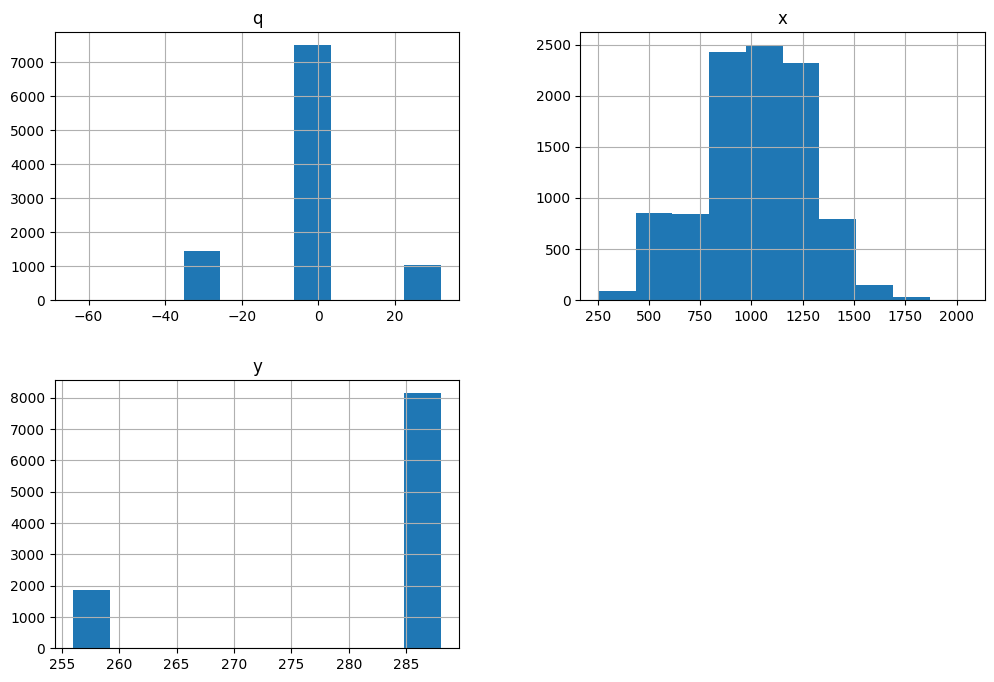

In [11]:
import pandas as pd

df = pd.DataFrame(stats)
df.hist(bins=10, figsize=(12, 8))
df.describe()